## Inception-v4

논문의 요약
1) 구조 :  Inception-ResNet 구조라 볼 수 있으며 v3대비 더 좋은 성능을 발휘

Inception-v4는 Inception 신경망을 좀 더 효과적으로 넓고 깊게 만들기 위해 고안되었습니다. Inception-v3보다 단순하고 획일화된 구조와 더 많은 Inception module을 사용합니다. Inception-ResNet은 Inception-v4에 residual connection을 결합한 것입니다. 학습 속도가 빨라졌다고 합니다.

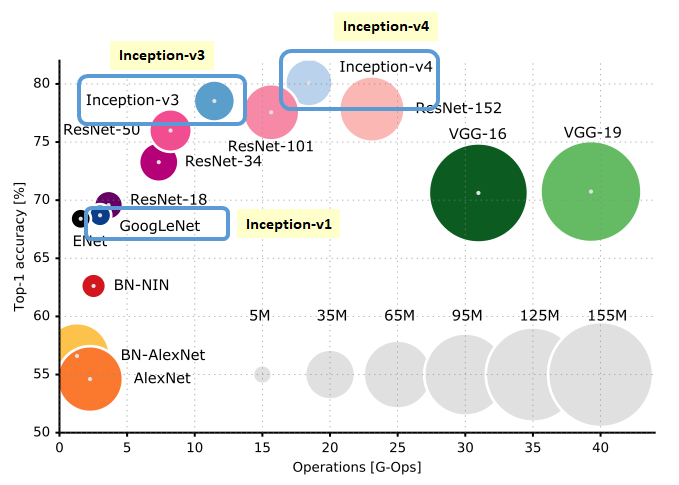

## 네트워크 구조 

논문에서는 Inception-v4, Inception-ResNet-v1, Inception-ResNet-v2 총 3가지 버전의 모델에 대해 설명하고 있으며, 살짝살짝씩 다른 부분이 있음

코드 구현은 https://deep-learning-study.tistory.com/537을 참조

In [1]:
import torch
import torch.nn as nn

In [2]:
## 가장 기본 모듈인 Conv2d 모듈 설계
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, bias = False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels) #eps는 기본값이 있으니 안쓴다..
        #분모가 0으로 되서 NaN방지하는게 eps값이니 신경쓰지말자.. 기본값 있음...
        self.relu = nn.ReLU(inplace=True)
        #inplace=True는 메모리 공간을 재사용해서 메모리 최적화를 하라는거임
    
    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        return x

모델의 Overrall 부분

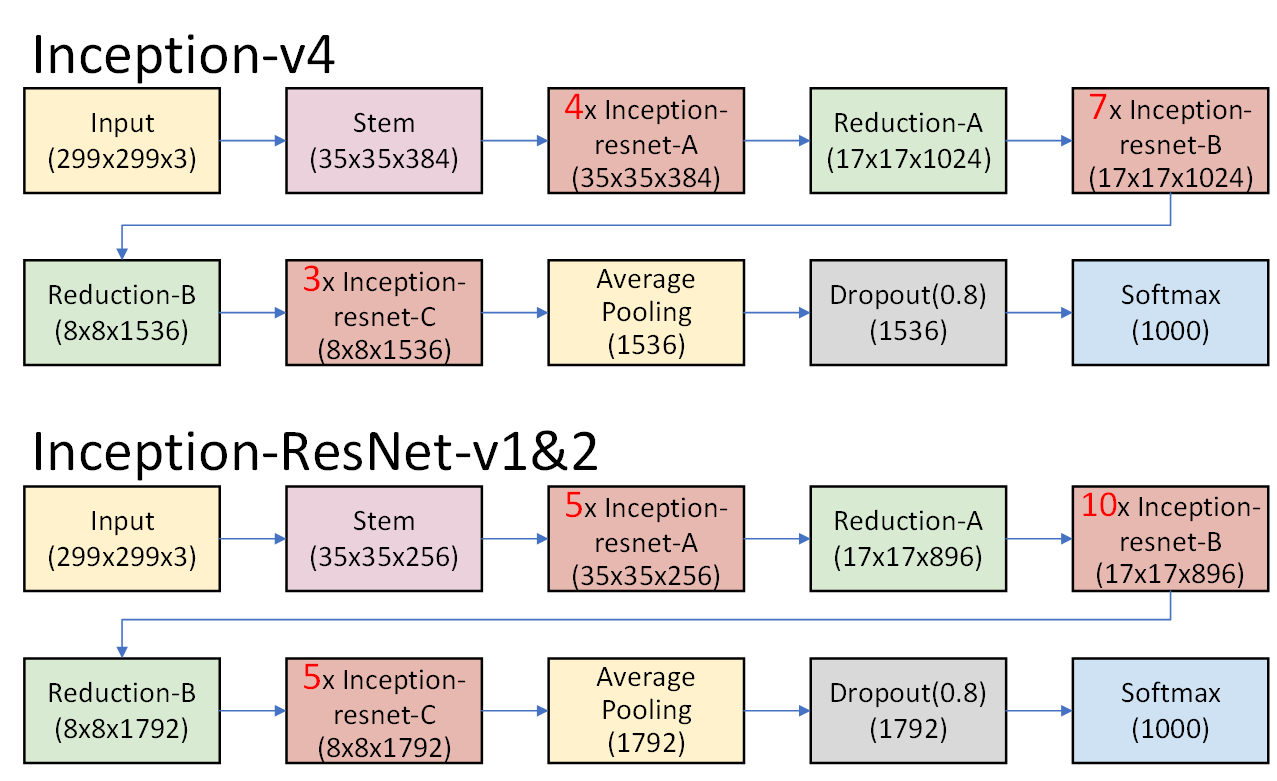

이제 stem, inception, reduction 모듈에 대한 설명 진행
이때 각 모듈의 세부사항으로 **V**라는 옵션이 붙는 모듈이 있음
이**V는 커널 또는 Valid Padding이 적용되고 V가 아닌 부분은 Same Padding이 적용되었다. 따라서 V로 표시된 부분은 Output Activation Map의 Grid Size가 감소하고 V로 표시되지 않은 부분은 Input과 Output의 Grid Size가 동일하다.**

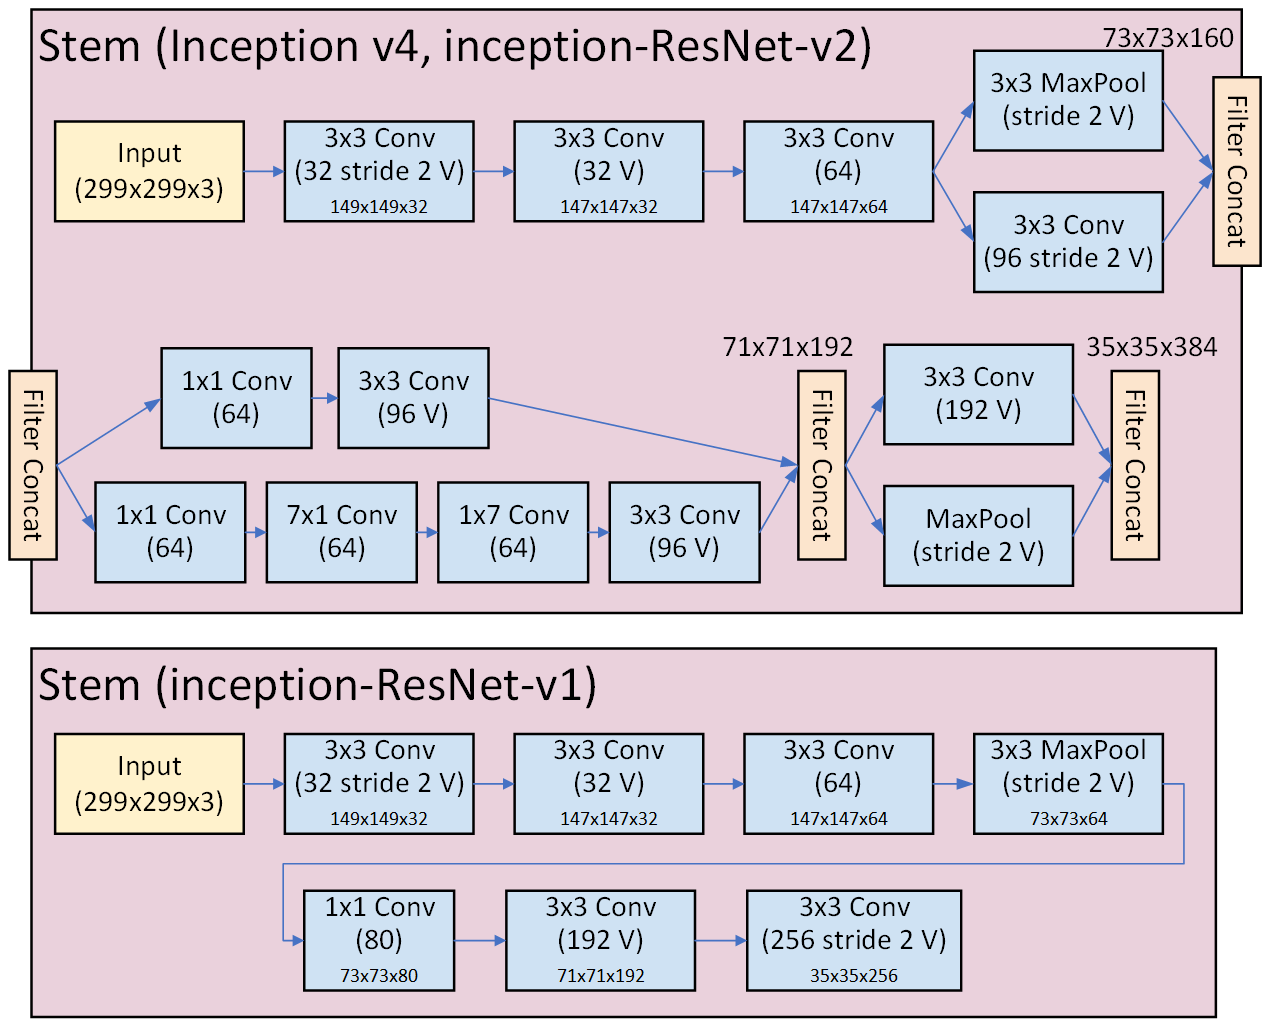

In [3]:
#코드 구현은 v4, resNet-v2 두개를 구현하자
class Stem(nn.Module):
    def __init__(self, in_channels):
        super(Stem, self).__init__()

        self.conv1 = nn.Sequential(
            BasicConv2d(in_channels, 32, kernel_size=3, stride=2, padding=0), #149x149x32
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=0), #147x147x32
            BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1) #147x147x64
        )

        self.branch1_Pool = nn.MaxPool2d(3, stride=2, padding=0) #73x7xx64
        self.branch1_Conv = BasicConv2d(64, 96, kernel_size=3, stride=2, padding=0)#73x73x96

        self.branch2_Conv = nn.Sequential(
            BasicConv2d(160, 64, kernel_size=1, stride=1, padding=0),
            BasicConv2d(64, 96, kernel_size=3, stride=1, padding=0)
        ) #71x71x96
        self.branch2_Conv_7x7 = nn.Sequential(
            BasicConv2d(160, 64, kernel_size=1, stride=1, padding=0),
            BasicConv2d(64, 64, kernel_size=(7,1), stride=1, padding=(3,0)),
            BasicConv2d(64, 64, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(64, 96, kernel_size=3, stride=1, padding=0)
        ) #71x71x96

        self.branch3_Conv = BasicConv2d(192, 192, kernel_size=3, stride=2, padding=0) #35x35x192
        self.branch3_Pool = nn.MaxPool2d(3, stride=2, padding=0) #35x35x192

    def forward(self, x):
        x = self.conv1(x)

        x1 = self.branch1_Pool(x)
        x2 = self.branch1_Conv(x)
        x = torch.cat([x1, x2], dim=1)

        x1 = self.branch2_Conv(x)
        x2 = self.branch2_Conv_7x7(x)
        x = torch.cat([x1, x2], dim=1)

        x1 = self.branch3_Conv(x)
        x2 = self.branch3_Pool(x)
        x = torch.cat([x1, x2], dim=1)
        
        return x

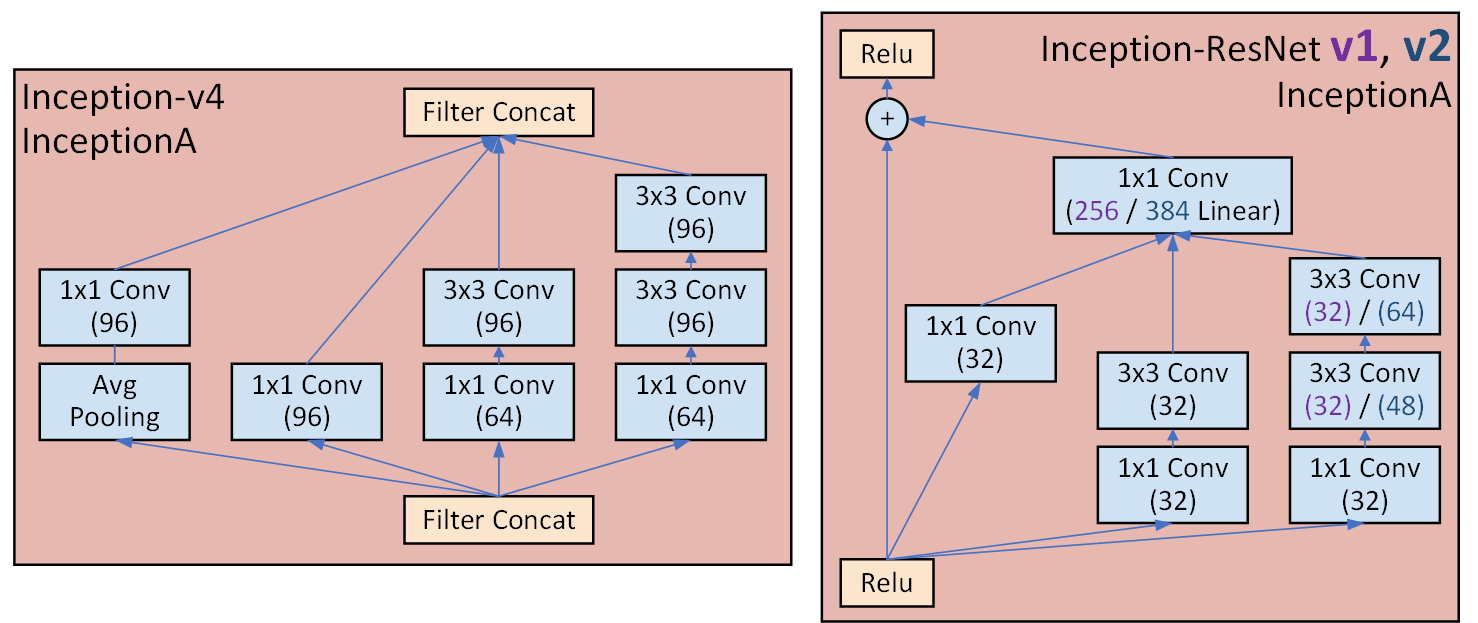

In [4]:
#코드 구현은 v4, resNet-v2 두개를 구현하자
class InceptionA_v4(nn.Module):
    def __init__(self, in_channels):
        super(InceptionA_v4, self).__init__()

        self.branch1 = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, 96, kernel_size=1, stride=1, padding=0)
        )
        self.branch2 = BasicConv2d(in_channels, 96, kernel_size=1, stride=1, padding=0)

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, 64, kernel_size=1, stride=1, padding=0),
            BasicConv2d(64, 96, kernel_size=3, stride=1, padding=1)
        )

        self.branch4 = nn.Sequential(
            BasicConv2d(in_channels, 64, kernel_size=1, stride=1, padding=0),
            BasicConv2d(64, 96, kernel_size=3, stride=1, padding=1),
            BasicConv2d(96, 96, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x4 = self.branch4(x)
        
        return torch.cat([x1, x2, x3, x4], dim=1)
        

class InceptionA_ResNet_v2(nn.Module):
    def __init__(self, in_channels):
        super(InceptionA_ResNet_v2, self).__init__()

        self.branch1 = BasicConv2d(in_channels, 32, kernel_size=1, stride=1, padding=0)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, 32, kernel_size=1, stride=1, padding=0),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, 32, kernel_size=1, stride=1, padding=0),
            BasicConv2d(32, 48, kernel_size=3, stride=1, padding=1),
            BasicConv2d(48, 64, kernel_size=3, stride=1, padding=1)
        )

        #여기서 128은 branch1~3의 아웃풋 출력 합산값이다.
        self.conv1x1_linear = nn.Conv2d(128, in_channels, kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x

        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat([x1, x2, x3], dim=1)

        out = self.conv1x1_linear(out)
        out = out + residual
        out = self.relu(out)

        return out

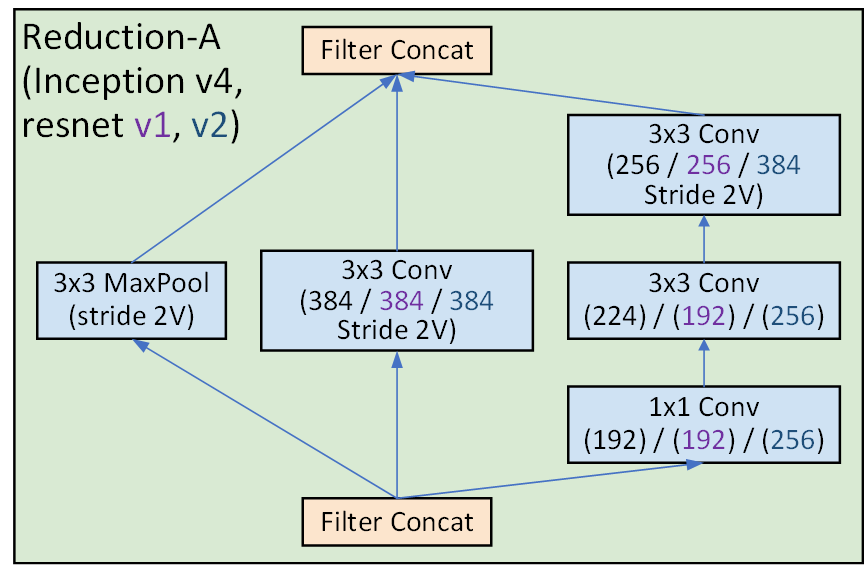

In [5]:
#코드 구현은 v4, resNet-v2 두개를 구현하자
# v4 : k=192, l=224, m=256, n=384
# resnet_v2 : k=256, l=256, m=384, n=384
class ReductionA(nn.Module):
    def __init__(self, in_channels, k, l, m, n):
        super(ReductionA, self).__init__()

        self.branch1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.branch2 = BasicConv2d(in_channels, n, kernel_size=3, stride=2, padding=0)
        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, k, kernel_size=1, stride=1, padding=0),
            BasicConv2d(k, l, kernel_size=3, stride=1, padding=1),
            BasicConv2d(l, m, kernel_size=3, stride=2, padding=0)
        )

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x = torch.cat([x1, x2, x3], dim=1)
        
        return x

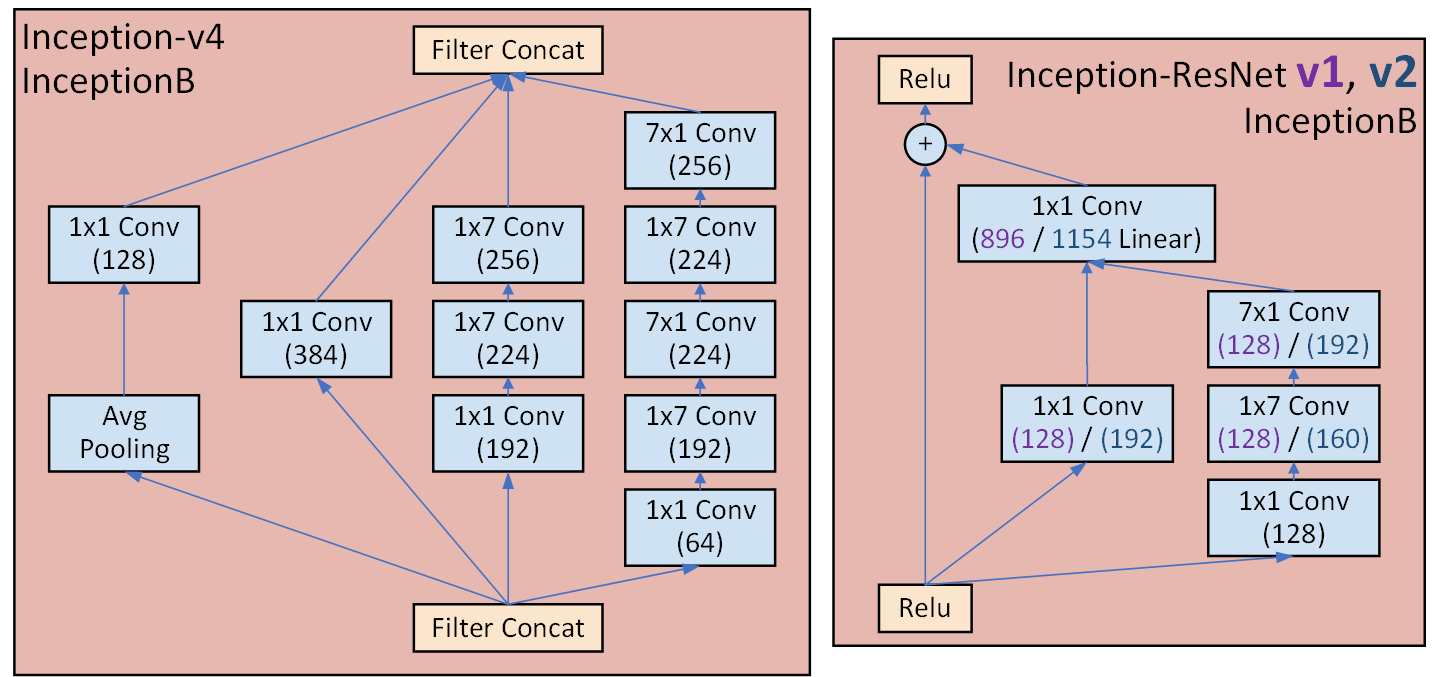

In [6]:
#코드 구현은 v4, resNet-v2 두개를 구현하자
class InceptionB_v4(nn.Module):
    def __init__(self, in_channels):
        super(InceptionB_v4, self).__init__()

        self.branch1 = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, 128, kernel_size=1, stride=1, padding=0)
        )
        self.branch2 = BasicConv2d(in_channels, 384, kernel_size=1, stride=1, padding=0)

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, 192, kernel_size=1, stride=1, padding=0),
            BasicConv2d(192, 224, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(224, 256, kernel_size=(7,1), stride=1, padding=(3,0))
        )

        self.branch4 = nn.Sequential(
            BasicConv2d(in_channels, 64, kernel_size=1, stride=1, padding=0),
            BasicConv2d(64, 192, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(192, 224, kernel_size=(7,1), stride=1, padding=(3,0)),
            BasicConv2d(224, 224, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(224, 256, kernel_size=(7,1), stride=1, padding=(3,0)),
        )

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x4 = self.branch4(x)
        
        return torch.cat([x1, x2, x3, x4], dim=1)
        

class InceptionB_ResNet_v2(nn.Module):
    def __init__(self, in_channels):
        super(InceptionB_ResNet_v2, self).__init__()

        self.branch1 = BasicConv2d(in_channels, 192, kernel_size=1, stride=1, padding=0)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, 128, kernel_size=1, stride=1, padding=0),
            BasicConv2d(128, 160, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(160, 192, kernel_size=(7,1), stride=1, padding=(3,0))
        )

        #여기서 384은 branch1~2의 아웃풋 출력 합산값이다.
        self.conv1x1_linear = nn.Conv2d(384, in_channels, kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x

        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat([x1, x2], dim=1)

        out = self.conv1x1_linear(out)
        out = out + residual
        out = self.relu(out)

        return out

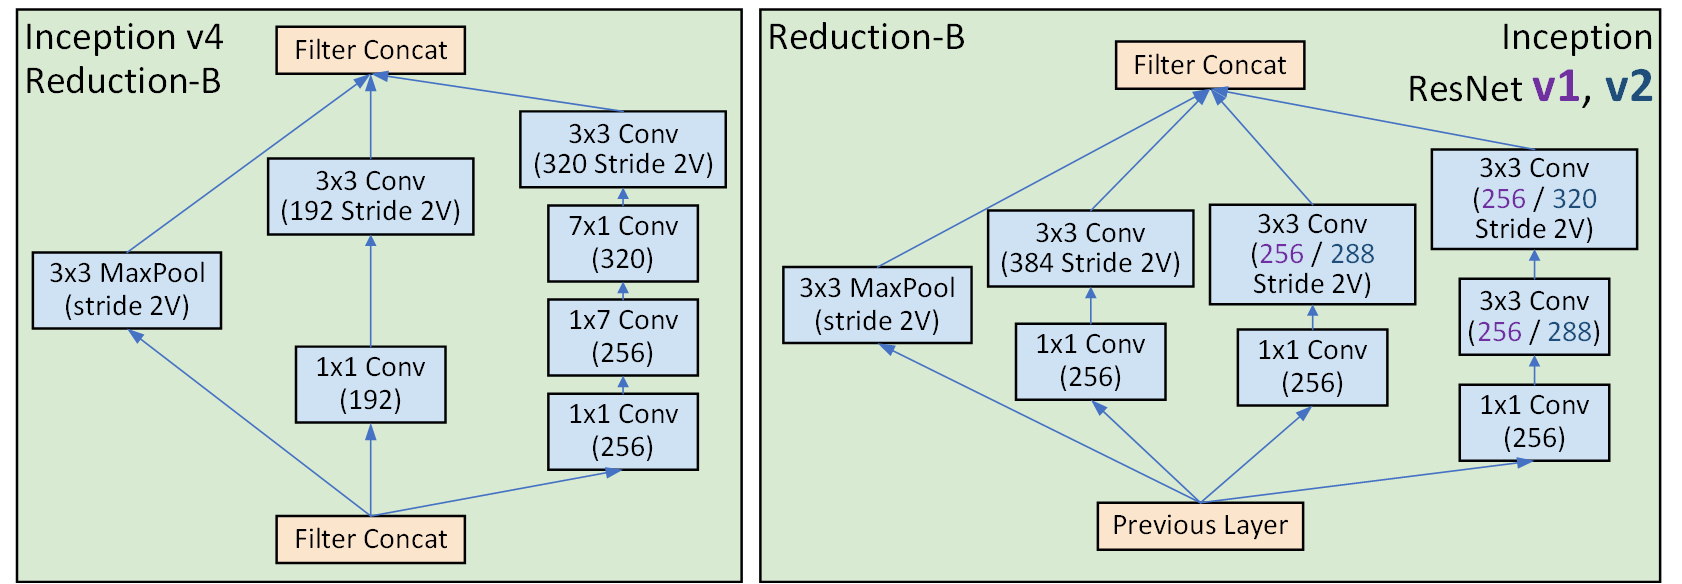

In [7]:
#코드 구현은 v4, resNet-v2 두개를 구현하자
class ReductionB_v4(nn.Module):
    def __init__(self, in_channels):
        super(ReductionB_v4, self).__init__()

        self.branch1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, 192, kernel_size=1, stride=1, padding=0),
            BasicConv2d(192, 192, kernel_size=3, stride=2, padding=0)
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, 256, kernel_size=1, stride=1, padding=0),
            BasicConv2d(256, 256, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(256, 320, kernel_size=(7,1), stride=1, padding=(3,0)),
            BasicConv2d(320, 320, kernel_size=3, stride=2, padding=0)
        )

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        
        return torch.cat([x1, x2, x3], dim=1)
    


class ReductionB_ResNet_v2(nn.Module):
    def __init__(self, in_channels):
        super(ReductionB_ResNet_v2, self).__init__()

        self.branch1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, 256, kernel_size=1, stride=1, padding=0),
            BasicConv2d(256, 384, kernel_size=3, stride=2, padding=0)
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, 256, kernel_size=1, stride=1, padding=0),
            BasicConv2d(256, 288, kernel_size=3, stride=2, padding=0)
        )

        self.branch4 = nn.Sequential(
            BasicConv2d(in_channels, 256, kernel_size=1, stride=1, padding=0),
            BasicConv2d(256, 288, kernel_size=3, stride=1, padding=1),
            BasicConv2d(256, 320, kernel_size=3, stride=2, padding=0)
        )

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x4 = self.branch4(x)

        return torch.cat([x1, x2, x3, x4], dim=1)

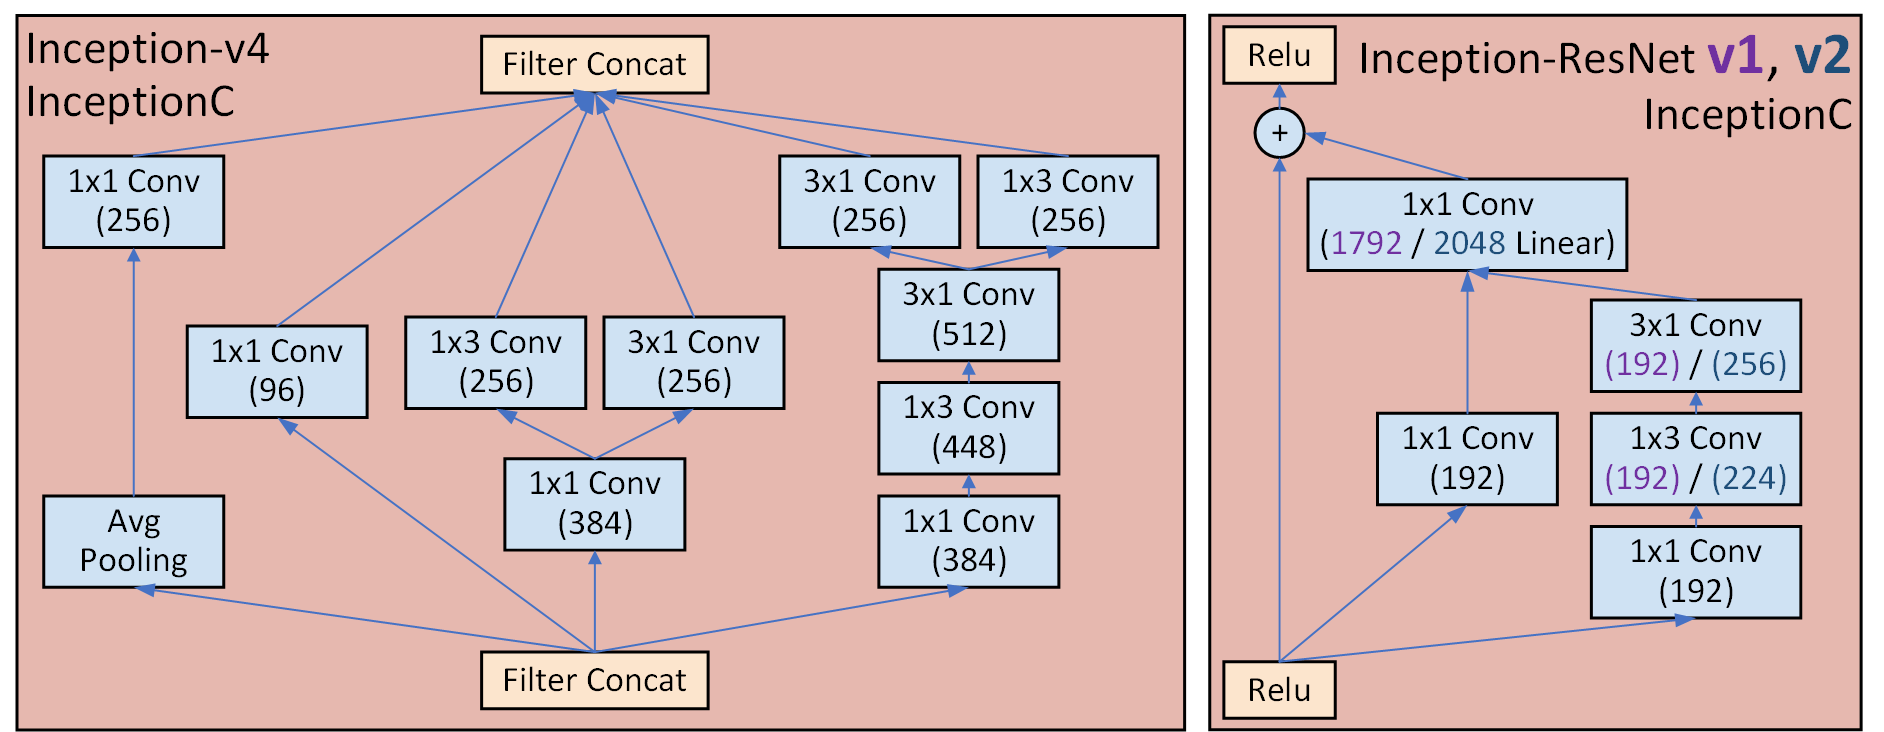

In [8]:
class InceptionC_v4(nn.Module):
    def __init__(self, in_channels):
        super(InceptionC_v4, self).__init__()

        self.branch1 = nn.Sequential(
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, 256, kernel_size=1, stride=1, padding=0)
        )

        self.branch2 = BasicConv2d(in_channels, 256, kernel_size=1, stride=1, padding=0)

        self.branch3 = BasicConv2d(in_channels, 384, kernel_size=1, stride=1, padding=0)
        self.branch3_1x3 = BasicConv2d(384, 256, kernel_size=(1,3), stride=1, padding=(0,1))
        self.branch3_3x1 = BasicConv2d(384, 256, kernel_size=(3,1), stride=1, padding=(1,0))

        self.branch4 = nn.Sequential(
            BasicConv2d(in_channels, 384, kernel_size=1, stride=1, padding=0),
            BasicConv2d(384, 448, kernel_size=(1,3), stride=1, padding=(0,1)),
            BasicConv2d(448, 512, kernel_size=(3,1), stride=1, padding=(1,0))
        )
        self.branch4_1x3 = BasicConv2d(512, 256, kernel_size=(1,3), stride=1, padding=(0,1))
        self.branch4_3x1 = BasicConv2d(512, 256, kernel_size=(3,1), stride=1, padding=(1,0))


    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)

        x3 = self.branch3(x)
        x3_1 = self.branch3_1x3(x3)
        x3_2 = self.branch3_3x1(x3)

        x4 = self.branch4(x)
        x4_1 = self.branch4_1x3(x4)
        x4_2 = self.branch4_3x1(x4)

        x = torch.cat([x1, x2, x3_1, x3_2, x4_1, x4_2], dim=1)
        return x
    
class InceptionC_ResNet_v2(nn.Module):
    def __init__(self, in_channels):
        super(InceptionC_ResNet_v2, self).__init__()

        self.branch1 = BasicConv2d(in_channels, 192, kernel_size=1, stride=1, padding=0)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, 192, kernel_size=1, stride=1, padding=0),
            BasicConv2d(192, 224, kernel_size=(1,3), stride=1, padding=(0,1)),
            BasicConv2d(224, 256, kernel_size=(3,1), stride=1, padding=(1,0))
        )

        #여기서 448은 branch1~2의 아웃풋 출력 합산값이다.
        self.conv1x1_linear = nn.Conv2d(448, in_channels, kernel_size=1, stride=1, padding=0)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x

        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat([x1, x2], dim=1)

        out = self.conv1x1_linear(out)
        out = out + residual
        out = self.relu(out)

        return out

In [9]:
class Inception_v4(nn.Module):
    def __init__(self, in_channels=3, num_classes=1000, 
                 k=192, l=224, m=256, n=384):
        super(Inception_v4, self).__init__()

        blocks = []
        blocks.append(Stem(in_channels))

        for _ in range(4):
            blocks.append(InceptionA_v4(384))
        blocks.append(ReductionA(384, k, l, m, n))

        for _ in range(7):
            blocks.append(InceptionB_v4(1024))
        blocks.append(ReductionB_v4(1024))

        for _ in range(3):
            blocks.append(InceptionC_v4(1536))
        
        self.features = nn.Sequential(*blocks)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.dropout = nn.Dropout2d(0.8)
        self.linear = nn.Linear(1536, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.linear(x)
        return x
    

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)




class Inception_ResNet_V2(nn.Module):
    def __init__(self, A=5, B=10, C=5, k=256, l=256, m=384, n=384, 
                 in_channels=3, num_classes=1000, init_weights=True):
        super(Inception_ResNet_V2, self).__init__()

        blocks = []
        blocks.append(Stem(in_channels))
        
        for _ in range(A):
            blocks.append(InceptionA_ResNet_v2(256))
        blocks.append(ReductionA(256, k, l, m, n))

        for _ in range(B):
            blocks.append(InceptionB_ResNet_v2(896))
        blocks.append(ReductionB_ResNet_v2(896))

        for _ in range(C):
            blocks.append(InceptionC_ResNet_v2(1792))

        self.features = nn.Sequential(*blocks)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        # drop out
        self.dropout = nn.Dropout2d(0.8)
        self.linear = nn.Linear(1792, num_classes)

        # weights inittialization
        # if init_weights:
        #     self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.linear(x)
        return x

    # define weight initialization function
    # def _initialize_weights(self):
    #     for m in self.modules():
    #         if isinstance(m, nn.Conv2d):
    #             nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    #             if m.bias is not None:
    #                 nn.init.constant_(m.bias, 0)
    #         elif isinstance(m, nn.BatchNorm2d):
    #             nn.init.constant_(m.weight, 1)
    #             nn.init.constant_(m.bias, 0)
    #         elif isinstance(m, nn.Linear):
    #             nn.init.normal_(m.weight, 0, 0.01)
    #             nn.init.constant_(m.bias, 0)

## 추가적으로 수행한 스킬 : Scalling of the Residuals

<div style="display: flex; align-items: flex-start;">
    <div style="flex: 1;">
        <img src="./img/image.png" alt="image" style="max-width: 100%; height: auto;">
    </div>
    <div style="flex: 1; padding-left: 10px;">
        논문에서 구성한 네트워크의 Filter 개수가 1000개를 넘어가면 모델이 죽는 현상이 발생하는데</br> 원인을 찾아보니 잔차연결(Skip connection)의 Residual Variants(잔차 분산)의 불안정성이 발생하는 것으로 파악됨</br>
        -> 따라서 문제 해결을 하기 위하여 Scalling Down을 적용하기로 함</br>
        -> 옆의 그림을 기반으로 Scalling down을 적용, Scalling Factor은 0.3~1.0임
    </div>
</div>

In [10]:
from torchsummary import summary #설계한 모델의 요약본 출력 모듈

debug_model = Inception_v4()
summary(debug_model, input_size=(3, 299, 299), device='cpu')



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
              ReLU-3         [-1, 32, 149, 149]               0
       BasicConv2d-4         [-1, 32, 149, 149]               0
            Conv2d-5         [-1, 32, 147, 147]           9,216
       BatchNorm2d-6         [-1, 32, 147, 147]              64
              ReLU-7         [-1, 32, 147, 147]               0
       BasicConv2d-8         [-1, 32, 147, 147]               0
            Conv2d-9         [-1, 64, 147, 147]          18,432
      BatchNorm2d-10         [-1, 64, 147, 147]             128
             ReLU-11         [-1, 64, 147, 147]               0
      BasicConv2d-12         [-1, 64, 147, 147]               0
        MaxPool2d-13           [-1, 64, 73, 73]               0
           Conv2d-14           [-1, 96,

c:\Users\HILS_AMD\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [11]:
# debug_model_2 = Inception_ResNet_V2()
# summary(debug_model_2, input_size=(3, 299, 299), device='cpu')

In [12]:
## 데이터셋 가져오기

import torchvision #예제 이미지 데이터셋이 모여있는 모듈
from torchvision import datasets, transforms

train_raw_data = datasets.STL10("rawdata", 
                                   split='train', 
                                   download=True, 
                                   transform=transforms.ToTensor())
test_raw_data = datasets.STL10("rawdata", 
                                   split='test', 
                                   download=True, 
                                   transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [13]:
import numpy as np

#이미지 전처리11 : RGB채널별 평균/표준편차 계산 함수 설계
def normal_parm_func(input_data):

    meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in input_data]
    stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in input_data]

    RGB_mean_list, RGB_std_list = [], []

    for i in range(3):
        RGB_mean_list.append(
            np.mean([m[i] for m in meanRGB])
        )
        RGB_std_list.append(
            np.mean([s[i] for s in stdRGB])
        )

    return RGB_mean_list, RGB_std_list


proc_train_data = normal_parm_func(train_raw_data)
proc_test_data = normal_parm_func(test_raw_data)

print(f"Train Mean: {[format(m, '.3f') for m in proc_train_data[0]]}, \
      Train Std: {[format(s, '.3f') for s in proc_train_data[1]]}")
print(f"Test Mean: {[format(m, '.3f') for m in proc_test_data[0]]}, \
      Test Std: {[format(s, '.3f') for s in proc_test_data[1]]}")

Train Mean: ['0.447', '0.440', '0.407'],       Train Std: ['0.224', '0.221', '0.224']
Test Mean: ['0.447', '0.440', '0.405'],       Test Std: ['0.225', '0.222', '0.224']


## 훈련 방법론

최적화 기법 : RMSProp 사용 -> 주요 파라미터
</br>Decay: 0.9 </br>Momentum: 0.9</br> Epsilon: 1.0</br> Initial Learning Rate: 0.045
</br>Learning Rate Decay: 지수적으로 감소시키며, 두 에포크마다 감소

## 데이터 전처리 및 증강(Argumentation)방법론

### 데이터 증강(Data Augmentation)

1. **랜덤 크롭(Random Crop)**:
   - 원본 이미지에서 임의의 크롭을 수행합니다. 일반적으로 8%에서 100% 사이의 임의 크기의 부분 이미지를 선택하고, 이를 네트워크 입력 크기(예: 299x299)로 리사이즈합니다.
   - 다양한 비율(aspect ratio)을 사용하여 크롭을 수행합니다.

2. **이미지 왜곡(Distortion)**:
   - 크롭된 이미지를 약간 회전시키거나 비율을 변경하여 왜곡합니다. 이는 모델이 다양한 시각적 변형에 대해 더 견고해지도록 합니다.

3. **색상 조정(Color Adjustment)**:
   - 이미지를 변형하여 다양한 색상 공간에서 학습할 수 있도록 합니다. 밝기, 대비, 채도, 색조 등의 속성을 무작위로 조정합니다.
   - 예를 들어, 이미지의 밝기를 무작위로 조정하거나 대비를 변경하는 등의 방법을 사용합니다.

### 데이터 전처리(Data Preprocessing)

1. **이미지 정규화(Normalization)**:
   - 각 픽셀 값을 [0, 1] 범위로 정규화합니다. 이는 모델이 더 빠르게 수렴하도록 도와줍니다.
   - 일반적으로 픽셀 값을 0과 1 사이로 스케일링합니다.

2. **리사이즈(Resize)**:
   - 입력 이미지의 크기를 고정된 크기(예: 299x299)로 조정합니다. 이는 네트워크에 일관된 입력 크기를 제공합니다.
   - 크롭된 이미지를 네트워크 입력 크기에 맞게 리사이즈합니다.

3. **채널 정규화(Channel Normalization)**:
   - 각 색상 채널(R, G, B)에 대해 정규화를 수행하여 평균이 0, 분산이 1이 되도록 합니다.
   - 이를 통해 모델이 색상 간의 차이를 더 잘 학습할 수 있도록 합니다.



In [14]:
#이미지 변환방식이 저장된 객체 생성
train_transformation = transforms.Compose([
    transforms.ToTensor(), 
    transforms.RandomResizedCrop((299, 299)), #Inception_V4 입력 이미지는 299 299 3임
    #그리고 1. 랜덤 크롭
    transforms.RandomHorizontalFlip(), #이건 안쓰는 적이 없음
    
    transforms.ColorJitter(brightness=32.0/255.0, contrast=0.5, 
                           saturation=0.5, hue=0.2),  #2번 색상조정
    
    transforms.RandomRotation(10),  # 3번 이미지 왜곡
    transforms.Normalize(mean=proc_train_data[0], std=proc_train_data[1])
    #이미지 정규화 -> 채널정규화
])
test_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((299, 299)), #Inception_V3 입력 이미지는 299 299 3임
    transforms.Normalize(mean=proc_train_data[0], std=proc_train_data[1])
    #훈련데이터의 평균, 표준편차 입력
])

#이미지에 위 변환방식을 적용
train_raw_data.transform = train_transformation
test_raw_data.transform = test_transformation

#데이터 로더 생성 -> 여기서 Batch_size를 정의함
train_loader = torch.utils.data.DataLoader(train_raw_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_raw_data, batch_size=64, shuffle=False)

In [15]:
#데이터로더 속성정보 출력 함수
#위 설정한 변수의 속성정보 출력하기
def count_images_and_labels(loader):
    num_images = 0
    label_set = set()
    for data, labels in loader:
        num_images += data.size(0)
        label_set.update(labels.tolist())
    
    return num_images, len(label_set)


train_images, train_label_count = count_images_and_labels(train_loader)
test_images, test_label_count = count_images_and_labels(test_loader)

print(f"Training Images: {train_images}, Unique Labels: {train_label_count}")
print(f"Testing Images: {test_images}, Unique Labels: {test_label_count}")

Training Images: 5000, Unique Labels: 10
Testing Images: 8000, Unique Labels: 10


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# CUDA가 사용 가능한 경우, 추가 정보 출력
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Capability: {torch.cuda.get_device_capability(0)}")
    print(f"Total Memory: {torch.cuda.get_device_properties(0).total_memory / (1024 ** 3):.2f} GB")  # GB 단위로 변환
    print(f"Number of GPUs: {torch.cuda.device_count()}")

cuda
GPU Name: NVIDIA GeForce RTX 4090
GPU Capability: (8, 9)
Total Memory: 23.99 GB
Number of GPUs: 1


In [17]:
ex_model = Inception_v4(in_channels = 3, num_classes=train_label_count)
ex_model.to(device)
summary(ex_model, input_size=(3, 229, 229), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 114, 114]             864
       BatchNorm2d-2         [-1, 32, 114, 114]              64
              ReLU-3         [-1, 32, 114, 114]               0
       BasicConv2d-4         [-1, 32, 114, 114]               0
            Conv2d-5         [-1, 32, 112, 112]           9,216
       BatchNorm2d-6         [-1, 32, 112, 112]              64
              ReLU-7         [-1, 32, 112, 112]               0
       BasicConv2d-8         [-1, 32, 112, 112]               0
            Conv2d-9         [-1, 64, 112, 112]          18,432
      BatchNorm2d-10         [-1, 64, 112, 112]             128
             ReLU-11         [-1, 64, 112, 112]               0
      BasicConv2d-12         [-1, 64, 112, 112]               0
        MaxPool2d-13           [-1, 64, 55, 55]               0
           Conv2d-14           [-1, 96,

c:\Users\HILS_AMD\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [18]:
import torch.nn.functional as F #이거는 활성화 함수 모듈
import torch.optim as optim


criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(ex_model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

## 여기서부터는 블로그의 학습 /훈련 코딩을 그대로 배껴온다...

In [19]:
import time

# function to get current learning rate
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# function to calculate metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

# function to calculate loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()

    return loss_b.item(), metric_b

# function to calculate loss per epoch
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric

# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_loss = float('inf')

    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            print('Get best val_loss!')

        lr_scheduler.step(val_loss)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    return model, loss_history, metric_history

In [20]:
import os

# definc the training parameters
params_train = {
    'num_epochs':100,
    'optimizer':optimizer,
    'loss_func':criterion,
    'train_dl':train_loader,
    'val_dl':test_loader,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error')
createFolder('./models')

In [21]:
odel, loss_hist, metric_hist = train_val(ex_model, params_train)

Epoch 0/99, current lr=0.001


c:\Users\HILS_AMD\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
c:\Users\HILS_AMD\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Get best val_loss!
train loss: 2.313511, val loss: 2.026856, accuracy: 19.70, time: 1.7293 min
----------
Epoch 1/99, current lr=0.001
Get best val_loss!
train loss: 2.145799, val loss: 2.001231, accuracy: 23.26, time: 3.4505 min
----------
Epoch 2/99, current lr=0.001
train loss: 2.076816, val loss: 2.269522, accuracy: 24.14, time: 5.1707 min
----------
Epoch 3/99, current lr=0.001
Get best val_loss!
train loss: 1.984514, val loss: 1.899725, accuracy: 26.31, time: 6.8917 min
----------
Epoch 4/99, current lr=0.001
Get best val_loss!
train loss: 1.938082, val loss: 1.816091, accuracy: 27.02, time: 8.6113 min
----------
Epoch 5/99, current lr=0.001
Get best val_loss!
train loss: 1.909102, val loss: 1.761197, accuracy: 28.81, time: 10.3325 min
----------
Epoch 6/99, current lr=0.001
Get best val_loss!
train loss: 1.890059, val loss: 1.692912, accuracy: 28.41, time: 12.0523 min
----------
Epoch 7/99, current lr=0.001
train loss: 1.875739, val loss: 1.709139, accuracy: 31.25, time: 13.7728

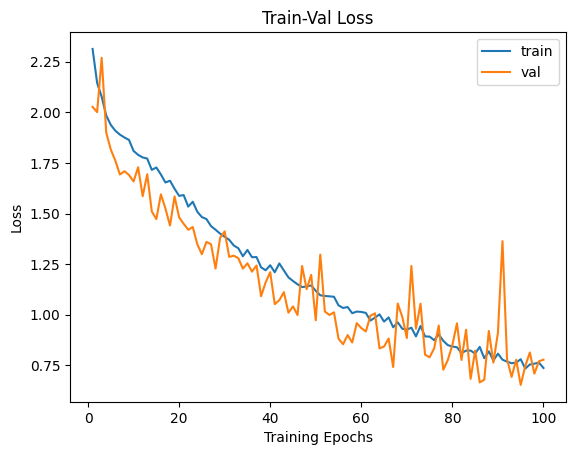

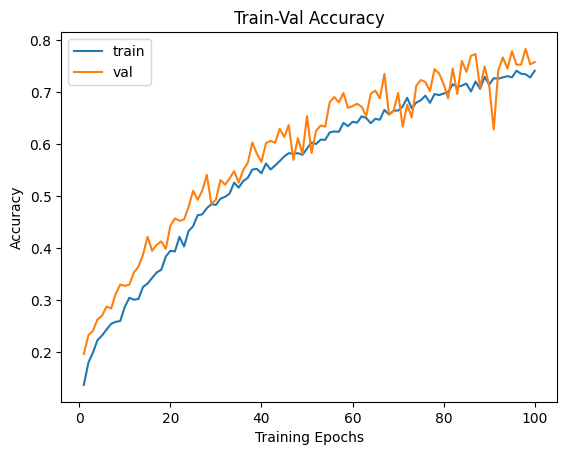

In [22]:
import matplotlib.pyplot as plt

# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()